## Chapter 3 Code

### Sampling from a grid-approximated posterior

The following code is how we generated the posterior from the globe tossing
example we did in the Chapter 2 notebook (only now with a Uniform(0,1) prior 
or, equivalently, Beta(1,1) prior).

In [3]:
import torch
import matplotlib.pyplot as plt
from scipy.stats import binom

In [4]:
p_grid = torch.linspace(0, 1, 1000)
prior = torch.ones((1000,))
likelihood = torch.tensor(binom.pmf(k=6, n=9, p=p_grid))
posterior = likelihood * prior
posterior = posterior / torch.sum(posterior)

Now that we have a posterior, we want to generate samples from it. The following
code samples from the posterior 10'000 times.

In [5]:
n_samples = int(1e4)
idx = torch.multinomial(posterior, num_samples=n_samples, replacement=True)
samples = p_grid[idx]

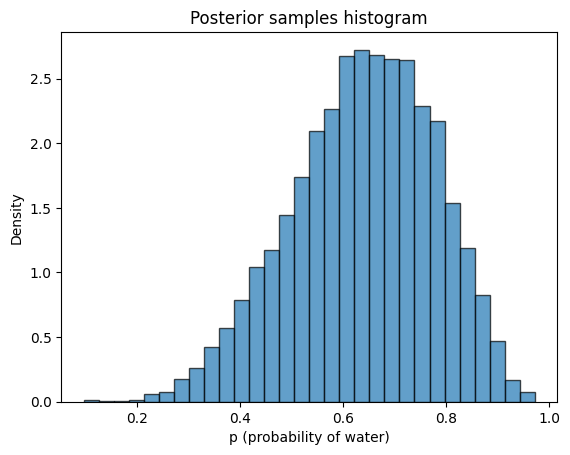

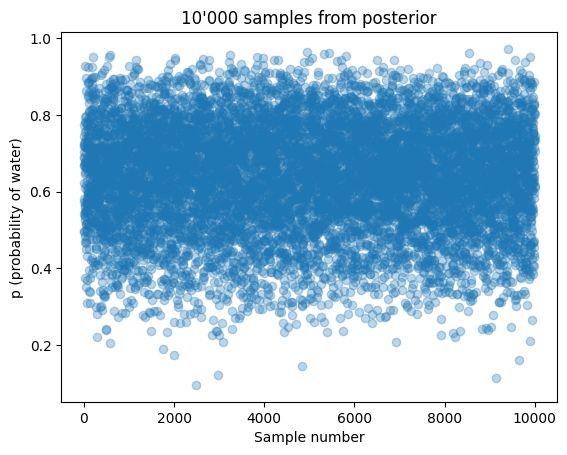

In [6]:
plt.hist(samples, bins=30, density=True, alpha=0.7, edgecolor='black')
plt.xlabel('p (probability of water)')
plt.ylabel('Density')
plt.title('Posterior samples histogram')
plt.show()

# Same plot output as in the textbook
plt.plot(samples, 'o', alpha=0.3)
plt.xlabel('Sample number')
plt.ylabel('p (probability of water)')
plt.title('10\'000 samples from posterior')
plt.show()

Both plots are views which show a more denser region of samples near the the 
region of $p=0.6$ and fewer samples below $p=0.25$.

### Sampling to summarize

The goal of modelling is such that our end goal is to produce a posterior 
distribution. Once we have a posterior distribution then comes the analysis work.

Part of the analysis work consists of positing a series of questions (which matter to our
goal) such that we may gain insight into the summary behaviour of the thing we
are modelling. Common questions include:
* How much (posterior) probability lies below/above/between some/two parameter
value(s)?
* Which parameter marks the lower 5% of the posterior probability?
* Which parameter value has the highest posterior probability?

These summary-based questions can be narrowed down into three categories. Questions
about:
1. Intervals of defined boundaries,
2. Intervals of defined probability mass,
3. Point estimates. 

What follows goes over how we can achieve answering these three classes of summary
questions.

#### Intervals of defined boundaries

We'd like to answer questions of the following flavour:

"What is the posterior probability that the proportion of water is less than 0.5".

This is one example. We may ask for greater than, or between two values. We want
to be able to answer this type of question using the samples we drew, and not with
the posterior density directly. The reason for this is that, in higher dimensional
settings, cumulating probabilities becomes more complicated to compute.

Using samples keeps things simple as all we need to do is to compute the frequency
of the behaviour of interest within our sample; and this translates to higher
dimensional problems.

The following finds:

The posterior probability that the proportion of water $p$ is less than 0.5. This
is done, as explained, by finding the frequency of parameter values that lie below
0.5

In [7]:
torch.sum(samples < 0.5) / 1e4

tensor(0.1683)

Since we are in a 1-dimensional scenario, we can compare this to the value we would
get by cummulating all the posterior probability mass using the posterior 
distribution directly:

In [8]:
# Add up all posterior probability where p < 0.5
idx = (p_grid < 0.5)
torch.sum(posterior[idx])

tensor(0.1719, dtype=torch.float64)

So we see that using either method, we agree upon roughly 17% of the posterior
probability being below 0.5.

The follow similar computation using the samples allows us to answer the question:
"How much posterior probability lies between 0.5 and 0.75":

In [9]:
mask = (samples > 0.5) & (samples < 0.75)
torch.sum(mask) / 1e4

tensor(0.6060)

We get that approximately 60% of the posterior probability lies between 0.5 and 0.75.

#### Intervals of defined probability mass

Intervals of defined probability mass, more commonly known as **confidence intervals**
are highly prevalent reports. In Bayesian analysis, when we report intervals of
defined probability mass, they are known as (Bayesian) **credible intervals**. There
are two main types of intervals considered when summarizing the posterior density
#### 1. The central interval of posterior density
* Corresponds, in the case of $100(1-\alpha)\%$ interval, to the range of values
above and below which lies exactly $100(\alpha/2)\%$ of the posterior density.
* For a 95% central interval of posterior density, we report back the interval
in which we take 2.5% probability mass from each tail. In other words, if I use
this particular interval if I want
to report which region of the posterior contains 95% of the posterior density such
that whatever mass I do not include (5%) it is equally split between the tails
(2.5% left out at the left tail, and 2.5% left out at the right tail).
* In current practice, is the interval of choice as it is (1) easier to compute
and (2) has direct interpretation as the posterior $\alpha/2$ and $1-\alpha/2$ quantiles.

If we want the 95% central posterior density interval, we simply return the
2.5% quantile and 97.5% quantile as the region. Said region will contain 95% of
the probability "mass", respecting that the tails equally exclude the same amount
of probability mass which sums up to the total amount of mass we wish not to consider
(2.5% + 2.5%  = 5%). Here it is for the globe example:

In [10]:
lower = samples.quantile(q=0.025)
upper = samples.quantile(q=0.975)
print(f"95% Central Posterior Density Interval:\n\n\t[{lower:.3f}, {upper:.3f}]")


95% Central Posterior Density Interval:

	[0.347, 0.879]


This interval assigns 2.5% of the probability mass above and below the interval
leaving 95% central probability.

**Potential flaws of the central interval**

While most commonly used, the central posterior density interval, which we'll call
the **percentile interval (PI)** to be consistent with the textbook, is not perfect
in all cases. In particular, they are not always great with supporting inferences 
about which parameters are consistent with the data. For example, if we have a 
highly skewed distribution, then the PI may fail to capture the region of most
probable parameters. Here is an example:

Consider the globe example only now we have just 3 observations all success.
The intuitively (and is the case), we should see highest posterior probability
mass near p=1 (100% success of landing on water):

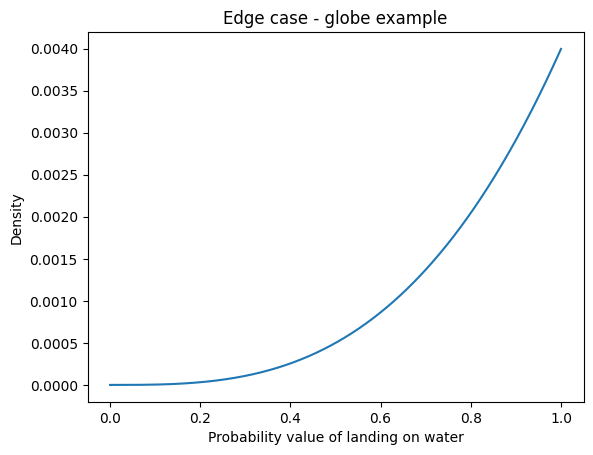

In [11]:
lik_edge_case = torch.tensor(binom.pmf(k=3, n=3, p=p_grid))
post_edge_case = lik_edge_case * prior
post_edge_case = post_edge_case / torch.sum(post_edge_case)

plt.plot(
    p_grid,
    post_edge_case
)
plt.xlabel('Probability value of landing on water')
plt.ylabel('Density')
plt.title('Edge case - globe example')
plt.show()

Now consider the 50% PI and notice that the PI will not capture the region 
where we have highest probability mass for the parameter $p$ (i.e. at $p=1$):

50% PI: [0.703, 0.929]


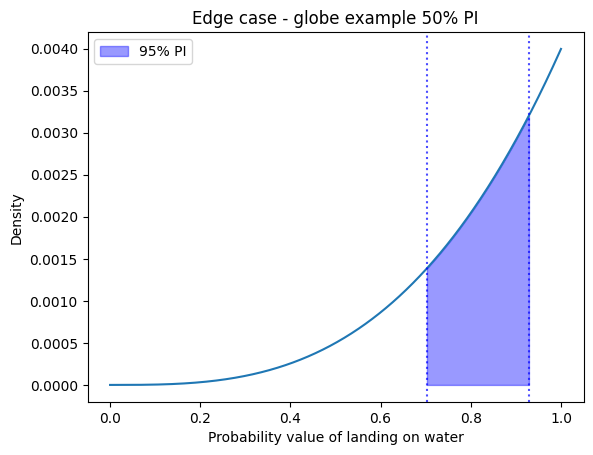

In [12]:
idx = torch.multinomial(post_edge_case, num_samples=n_samples, replacement=True)
edge_samples = p_grid[idx]
lower_edge = edge_samples.quantile(q=0.25)
upper_edge = edge_samples.quantile(q=0.75)
print(f"50% PI: [{lower_edge:0.3f}, {upper_edge:0.3f}]")

x_fine = torch.linspace(edge_samples.min(), edge_samples.max(), 1000).numpy()

plt.plot(
    p_grid,
    post_edge_case
)
plt.fill_between(
    p_grid,
    post_edge_case,
    where=(p_grid >= lower_edge.item()) & (p_grid <= upper_edge.item()),
    color="blue",
    alpha = 0.4, label='95% PI'
)

plt.axvline(lower_edge.item(), color='blue', linestyle=':', alpha=0.7)
plt.axvline(upper_edge.item(), color='blue', linestyle=':', alpha=0.7)

plt.xlabel('Probability value of landing on water')
plt.ylabel('Density')
plt.title('Edge case - globe example 50% PI')
plt.legend()    
plt.show()

#### 2. The highest posterior density interval (HPDI)
* It is the narrowest interval containing $100(1-\alpha)%$ posterior density,
* We can generate an infinite number of intervals containing, say, 50% mass,
but the HDPI is the one which is most dense (narrowest),
* HPDIs give intervals that best represent the parameter values most consistent
with the data, i.e. capture the parameters which have the highest posterior density.

**Flaws of the HPDI**
* HPDI is more computationally intensive to compute (may require optimization),
* Suffers greater simulation variance, i.e. sensitive to sample size drawn from posterior,
* Generally harder to understand.

The following code gives the 50% HPDI interval in our edge case above. 
What we see in the plot is that,
in terms of capturing the region of parameters most consistent with the data, this
interval better describes that compared to the PI.

50% HPDI: [0.837, 1.000]


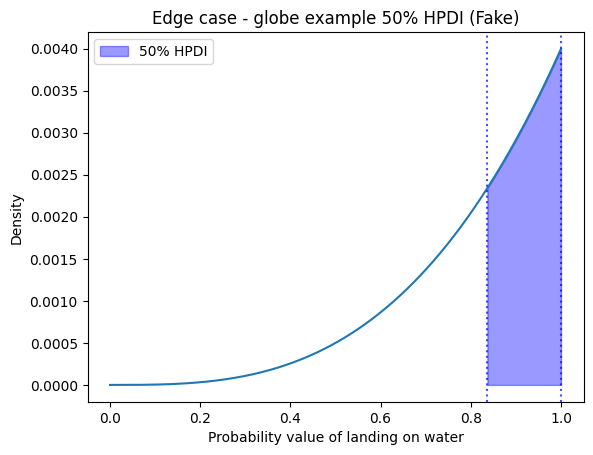

In [17]:
# The following code was taken from: https://github.com/ecotner/statistical-rethinking/blob/master/notebooks/03_sampling_the_imaginary.ipynb
def HPDI(samples, prob):
    samples = sorted(samples)
    N = len(samples)
    W = int(round(N*prob))
    min_interval = float('inf')
    bounds = [0, W]
    for i in range(N-W):
        interval = samples[i+W] - samples[i]
        if interval < min_interval:
            min_interval = interval
            bounds = [i, i+W]
    return samples[bounds[0]], samples[bounds[1]]

q1, q2 = HPDI(edge_samples, 0.50)

print(f"50% HPDI: [{q1:.3f}, {q2:.3f}]")

plt.plot(
    p_grid,
    post_edge_case
)
plt.fill_between(
    p_grid,
    post_edge_case,
    where=(p_grid >= q1) & (p_grid <= q2),
    color="blue",
    alpha = 0.4, label='50% HPDI'
)

plt.axvline(q1, color='blue', linestyle=':', alpha=0.7)
plt.axvline(q2, color='blue', linestyle=':', alpha=0.7)

plt.xlabel('Probability value of landing on water')
plt.ylabel('Density')
plt.title('Edge case - globe example 50% HPDI (Fake)')
plt.legend()    
plt.show()

**Final Notes:**

* When we are dealing with a unimodal symmetric distribution the PI and HPDI are
identical.
* While the HPDI conveys more information when we are dealing with more "ugly"
distributions, the times where we get a significant boost of information usually
are distributions that are best described not by a single interval anyways.

# Exercises

### Medium Exercises

#### 3M1

Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

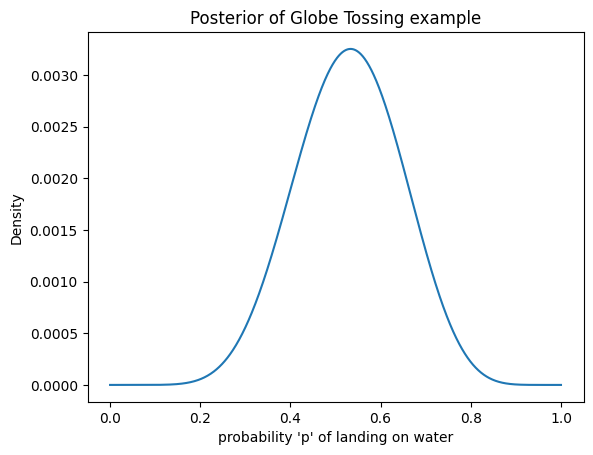

In [18]:
# Constructing the posterior = likelihood * prior / marginal
p_grid = torch.linspace(0, 1, 1000)
likelihood = torch.tensor(binom.pmf(8, 15, p_grid))
prior = torch.ones((1000,)) # flat prior i.e. uniform[0,1]
posterior = likelihood * prior
posterior = posterior / torch.sum(posterior)

# Plot the posterior
plt.plot(
    p_grid,
    posterior
)
plt.xlabel("probability 'p' of landing on water")
plt.ylabel("Density")
plt.title("Posterior of Globe Tossing example")
plt.show()

#### 3M2
Draw 10,000 samples from the grid approximation from above. 
Then use the samples to calculate the 90% HPDI for p.

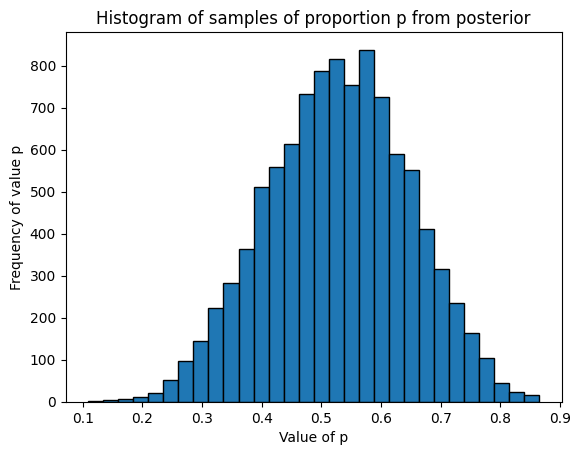

In [19]:
# Drawing 10'000 samples and plotting samples
n_samples = int(1e4)
idx = torch.multinomial(posterior, n_samples, replacement=True)
samples = p_grid[idx]

plt.hist(
    samples,
    bins=30,
    density=False,
    edgecolor="black"
)
plt.xlabel("Value of p")
plt.ylabel("Frequency of value p")
plt.title("Histogram of samples of proportion p from posterior")
plt.show()

90% HPDI: [0.340, 0.731]


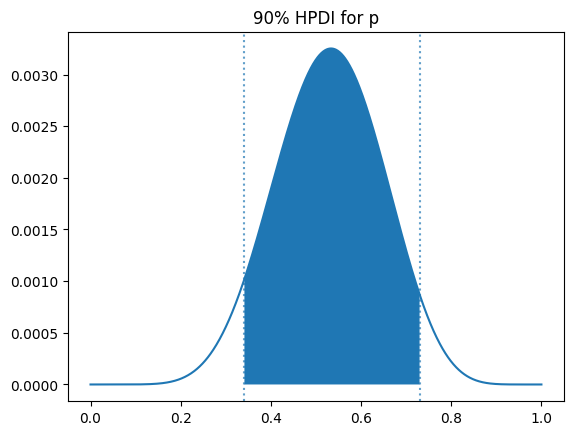

In [20]:
# Computing 90% HPDI for p
q1, q2 = HPDI(samples, 0.90)
print(f"90% HPDI: [{q1:.3f}, {q2:.3f}]")

# Plot the shaded region
mask = (q1 < p_grid) & (q2 > p_grid)
plt.plot(
    p_grid,
    posterior
)
plt.fill_between(p_grid[mask], posterior[mask], 0)
plt.axvline(q1, alpha=0.7, linestyle=':')
plt.axvline(q2, alpha=0.7, linestyle=':')
plt.title("90% HPDI for p")
plt.show()

#### 3M3
Constuct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in $p$. What is the probability of observing 8 water in 15 tosses?

Snippet from the book to help:


"For each sampled value, a random binomial observation is generated. 
Since the sampled values appear in proportion to their 
posterior probabilities, the resulting simulated observations are 
averaged over the posterior." 

In other words:
1. Get the posterior w.r.t $p$ (done)
2. For each sampled $p^{(s)}$, simulate a new data point 
    $\tilde y^{(s)} \sim \text{Binomial}(n, p^{(s)})$
3. The collection $\{\tilde y^{(s)}\}$ is a sample from the posterior predictive distribution

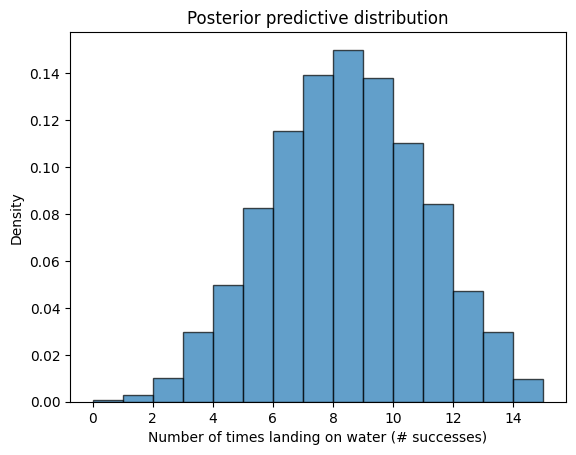

In [22]:
# So we want to generate samples for each of the different possible values of p
# then we form the posterior predictive by averaging over them all

# Since we use our samples as the probabilities, we are already weighting with
# respect to the posterior. This lines up with the definition of the posterior
# predictive integral {binomial-likelihood(w) * posterior(w)}dw
w = torch.tensor(binom.rvs(n=15, p=samples))
plt.hist(
    w,
    bins=15,
    density=True,
    edgecolor="black",
    alpha=0.7
)
plt.xlabel("Number of times landing on water (# successes)")
plt.ylabel("Density")
plt.title("Posterior predictive distribution")
plt.show()

In [23]:
# Getting the probability of 8 waters out of 15 tosses
# We do this by computing the frequency of samples equating to 8 out of the total
possible_vals, counts = torch.unique(w, return_counts=True)
p8 = counts[(possible_vals==8)] / torch.sum(counts)
print(f"Probability of 8 Waters in 15 Tosses: {float(p8):.3f}")

Probability of 8 Waters in 15 Tosses: 0.150


#### 3M4

Using the posterior distribution constructed from the new (8/15) data, 
now calculate the probability of observing 6 water in 9 tosses.

In [52]:
w = torch.tensor(binom.rvs(n=9, p=samples))
possible_vals, counts = torch.unique(w, return_counts=True)
p6 = counts[possible_vals==6] / torch.sum(counts)
print(f"Probability of 6 Waters in 9 Tosses: {float(p6):.3f}")

Probability of 6 Waters in 9 Tosses: 0.175


#### 3M5

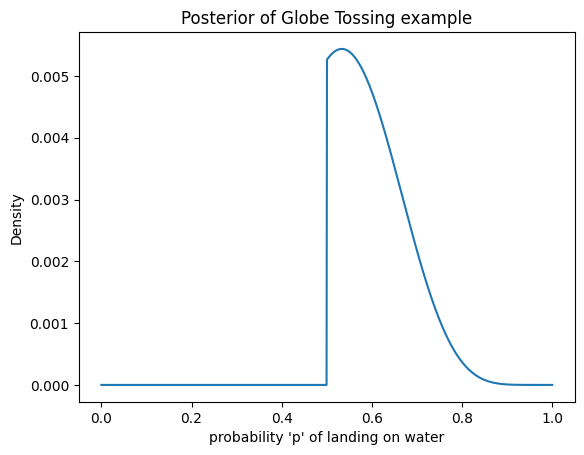

In [24]:
# Constructing the posterior = likelihood * prior / marginal
p_grid = torch.linspace(0, 1, 1000)
likelihood = torch.tensor(binom.pmf(8, 15, p_grid))
prior = torch.where(p_grid >= 0.5, 1.0, 0.0) # 1 when p>=0.5, 0 elsewhere
posterior = likelihood * prior
posterior = posterior / torch.sum(posterior)

# Plot the posterior
plt.plot(
    p_grid,
    posterior
)
plt.xlabel("probability 'p' of landing on water")
plt.ylabel("Density")
plt.title("Posterior of Globe Tossing example")
plt.show()

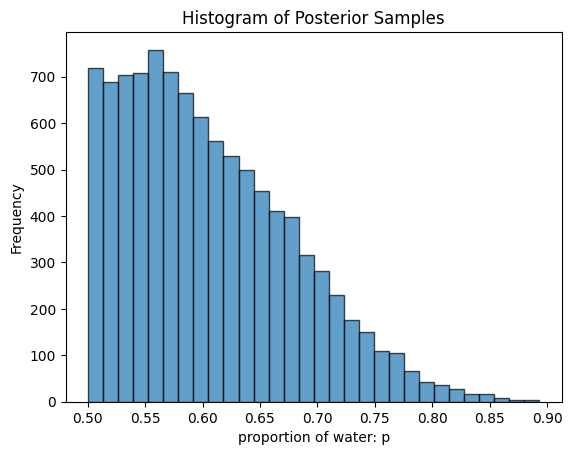

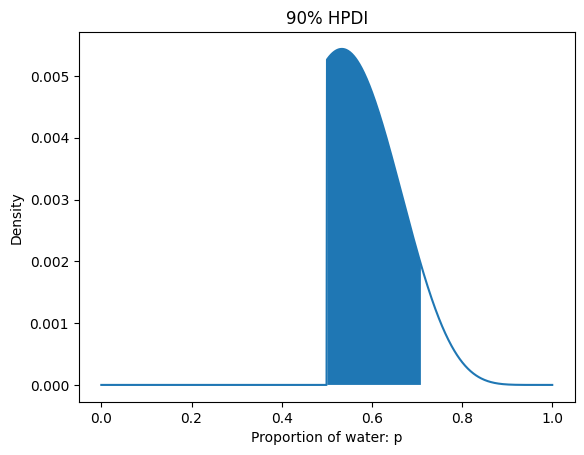

In [27]:
# Drawing 10'000 samples
n_samples = int(1e4)
idx = torch.multinomial(posterior, n_samples, replacement=True)
samples = p_grid[idx]

q1, q2 = HPDI(samples, 0.90)

plt.hist(
    samples,
    bins=30,
    edgecolor="black",
    alpha=0.7
)
plt.xlabel("proportion of water: p")
plt.ylabel("Frequency")
plt.title("Histogram of Posterior Samples")
plt.show()

mask = (q1 < p_grid) & (p_grid < q2)
plt.plot(
    p_grid,
    posterior
)
plt.fill_between(p_grid[mask], posterior[mask], 0)
plt.xlabel("Proportion of water: p")
plt.ylabel("Density")
plt.title("90% HPDI")
plt.show()

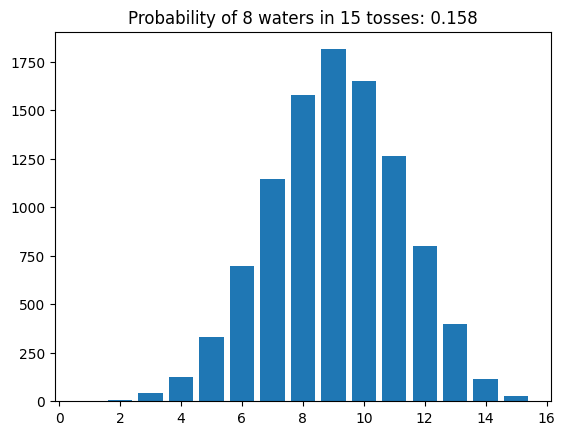

Probability of 8 waters in 15 tosses 0.15770000219345093


In [ ]:
# Posterior predictive check
w = torch.tensor(binom.rvs(n=15, p=samples))
vals, counts = torch.unique(w, return_counts=True)
plt.bar(vals, counts)
p8 = (counts[vals==8]/counts.sum()).item()
plt.title(f"Probability of 8 waters in 15 tosses: {p8:.3f}")
plt.show()

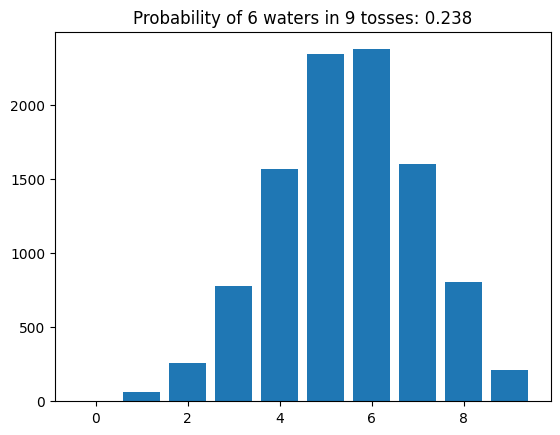

In [32]:
w = torch.tensor(binom.rvs(n=9, p=samples))
vals, counts = torch.unique(w, return_counts=True)
plt.bar(vals, counts)
p6 = (counts[vals==6]/counts.sum()).item()
plt.title(f"Probability of 6 waters in 9 tosses: {p6:.3f}")
plt.show()